# Ультрадыбыстық суреттер арқылы қалқанша без патологиясын анықтау

## Жобаның мақсаты:
Қалқанша безінің УЗИ (ультрадыбыстық зерттеу) суреттеріне негізделіп, оның **қатерлі (malignant)** немесе **қатерсіз (benign)** екенін анықтайтын **нейрондық модель** құру.

Модель медицина қызметкерлеріне шешім қабылдауда көмек көрсетуге, уақытты үнемдеуге және адам қатесін азайтуға бағытталған.

---

## Модель талаптары:

- Машиналық оқыту әдістерін қолданып УЗИ суреттерін классификациялау
- Бірнеше CNN архитектураларын салыстыру
- Жоғары дәлдік және визуалды интерпретация (GradCAM, ROC)
- Ноутбуктық ресурстарда (CPU + 16GB RAM) жұмыс істей алатындай етіп оңтайландыру
- Финалдық модельді Flask серверге интеграциялауға дайын күйге жеткізу

---

## Деректер:

- 6005 УЗИ кескін (Batch 1)
- `.csv` файл арқылы сурет ID және диагноз (benign / malignant)
- Әр сурет нақты диагнозбен аннотталған

---

## Қолданылатын технологиялар:

- Python, TensorFlow/Keras
- NumPy, Pandas, Matplotlib
- OpenCV, Seaborn
- CNN + Transfer Learning (MobileNetV2)

---

In [2]:
# Этап 0 — Қажетті кітапханаларды импорттау және тексеру

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
# TensorFlow және құрылғылар туралы ақпарат
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU қолжетімді ме: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU қолжетімді ме: []


---

##  Этап 1 — Деректер құрылымын түсіну және өңдеу

###  1.1 Деректер құрылымы

Біз қолданатын УЗИ деректер жиыны екі компоненттен тұрады:

1. **Сурет папкасы — `batch1_image/`**
   - Барлық 6005 УЗИ кескін осы папкада сақталған
   - Сурет атауы: `image_id.jpg` (`0_001.jpg`, `5_328.jpg` т.б.)
   - Сурет өлшемі — әртүрлі, кейін `resize` жасаймыз

2. **Аннотация файлы — `batch1_image_label.csv`**
   - Әрбір суретке қатысты метаақпарат пен диагноз
   - Негізгі бағандар:
     - `Image`: суреттің ID (`5_328`)
     - `Diagnosis`: `benign` немесе `malignant`
   - Бұл файлды Pandas көмегімен жүктеп, суреттермен байланыстырамыз

---

 Мақсат: сурет атауы мен диагнозды біріктіріп, дайын `DataFrame` жасау.

In [9]:
# Путьті көрсетіңіз (өзгерту керек болса)
LABELS_PATH = "./dataset/batch1_image_label.csv"

# CSV оқу
labels_df = pd.read_csv(LABELS_PATH)

# Алғашқы 5 жолды көру
labels_df.head()

,patient_name,histo_label
0,502,0
1,288,1
2,323,0
3,178,0
4,427,1


###  1.2 CSV жүктеу

Аннотация файлы (`batch1_image_label.csv`) — суреттердің атауы (`Image`) мен диагнозын (`Diagnosis`) қамтиды.  
Әр жол — нақты бір УЗИ суретке сәйкес келеді.

Мақсатымыз — бұл деректерді оқу және диагноздарды талдау.

---

###  1.3 Диагноз кластарын талдау

- `benign` — қатерсіз түйіндер
- `malignant` — қатерлі түйіндер
- Сыныптар арасында елеулі **дисбаланс** бар:
  - **218** пациент — benign
  - **383** пациент — malignant

 Бұл дисбаланс модель оқыту кезінде `class_weight='balanced'` стратегиясын талап етеді.

In [14]:
print(" Қол жетімді бағандар:")
print(labels_df.columns.tolist())

 Қол жетімді бағандар:
['patient_name', 'histo_label']


 Қол жетімді диагноз мәндері (histo_label):
histo_label
1    383
0    218
Name: count, dtype: int64


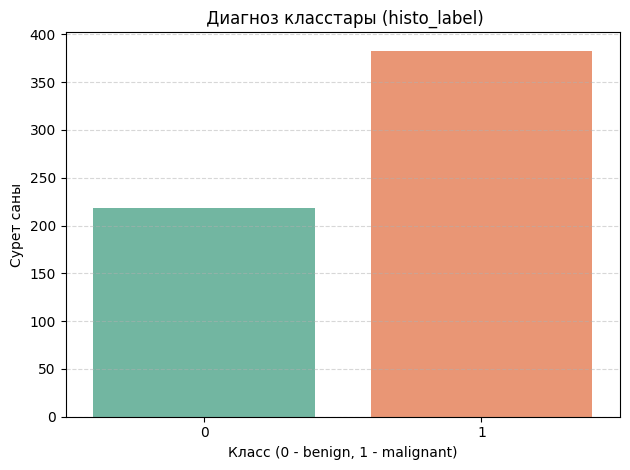

In [16]:
# Диагноз бағанының атын жаңарту
print(" Қол жетімді диагноз мәндері (histo_label):")
print(labels_df['histo_label'].value_counts())

# Класстар балансын визуалдау
sns.countplot(data=labels_df, x='histo_label', palette='Set2')
plt.title(" Диагноз класстары (histo_label)")
plt.xlabel("Класс (0 - benign, 1 - malignant)")
plt.ylabel("Сурет саны")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

---

##  Этап 2 — Суреттерді жүктеу және қайта өңдеу (Preprocessing)

### 2.1 Суреттерді оқу

УЗИ кескіндері `batch1_image/` папкасында сақталған.  
Суреттерді `OpenCV` немесе `PIL` көмегімен **grayscale** режимінде оқимыз.

> Grayscale — медицинада жиі қолданылатын формат және модельге тиімді.

---

### 2.2 Суреттің өлшемін азайту

Барлық суреттерді бірдей өлшемге келтіреміз. Бұл:
- Модельге біркелкі кіріс беру
- Жадты үнемдеу
- CPU арқылы оқу процесін жеделдету

> Ұсынылған өлшем: **128x128 пиксель**

---

### 2.3 Белгілерді біріктіру

`.csv` ішіндегі **пациент ID, image name** және `label (histo_label)` бағандарын пайдаланып,  
суреттің нақты `image_path` жолын құрып, сәйкес `label`-мен бірге `X`, `y` массивтерін құрамыз.

> Әрбір жол: `X[i] = image (numpy array), y[i] = 0/1`


In [110]:
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm

# Папка жолы және өлшем
IMAGES_DIR = "./dataset/batch1_image/"
IMG_SIZE = 128

# 1. CSV оқу
df_labels = pd.read_csv("./dataset/batch1_image_label.csv")  # patient_name, histo_label
df_paths = pd.read_csv("./dataset/batch1_image.csv")         # patient_name, path

# 2. Біріктіру (науқасқа диагноз беру үшін)
df = pd.merge(df_paths, df_labels, on="patient_name")

# 3. Толық сурет жолын жасау
df['image_path'] = df['path'].apply(lambda x: os.path.join(IMAGES_DIR, x))

# 4. Сурет жүктеу және өңдеу
X_data = []
y_data = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Суреттерді өңдеу"):
    path = row['image_path']
    label = row['histo_label']  # суреттің белгісі — науқастың диагнозы

    if os.path.exists(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32') / 255.0  # нормализация
        X_data.append(img)
        y_data.append(label)

# NumPy форматқа ауыстыру
X_data = np.expand_dims(np.array(X_data), axis=-1)  # grayscale → (N, H, W, 1)
y_data = np.array(y_data)

# Нәтиже
print(f"Сурет массиві: {X_data.shape}")
print(f"Label массиві: {y_data.shape}")
print(f"Қатерлі үлес: {np.mean(y_data):.2f} (1 = malignant)")

Суреттерді өңдеу: 100%|███████████████████████████████████████████████████████████| 6005/6005 [00:11<00:00, 523.35it/s]


Сурет массиві: (3398, 128, 128, 1)
Label массиві: (3398,)
Қатерлі үлес: 0.63 (1 = malignant)


---

##  Этап 3 — EDA және визуализация

###  Мақсат:

Бұл бөлімде біз ультрадыбыстық кескіндер мен олардың класстық үлестірімі жайлы жалпы түсінік аламыз:

-  **Класстар балансы** — benign vs malignant
-  **Суреттер мысалдары** — визуалды қарап шығу
-  **Кейстер шолуы** — қатерлі және қатерсіз кескіндерді салыстыру

Бұл визуализациялар деректердің сапасы мен таралуын көруге көмектеседі және модель оқыту алдында алдын ала бақылау жасайды.


 Класстар үлестірімі:
Benign (0): 1253
Malignant (1): 2145


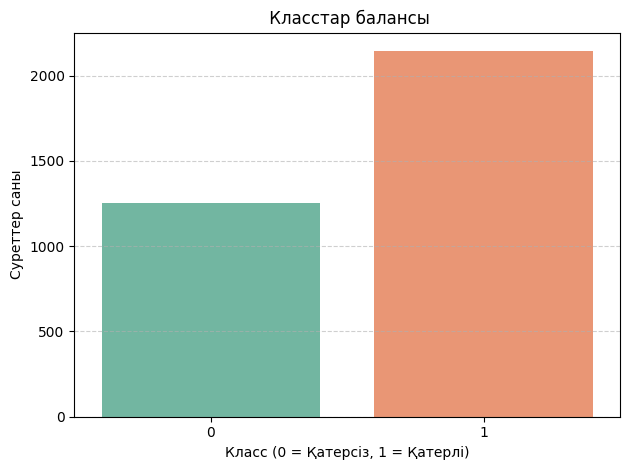

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

#  Балансты санмен көру
unique, counts = np.unique(y_data, return_counts=True)
print(f" Класстар үлестірімі:\nBenign (0): {counts[0]}\nMalignant (1): {counts[1]}")

#  Визуализация
sns.countplot(x=y_data, palette='Set2')
plt.title(" Класстар балансы")
plt.xlabel("Класс (0 = Қатерсіз, 1 = Қатерлі)")
plt.ylabel("Суреттер саны")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


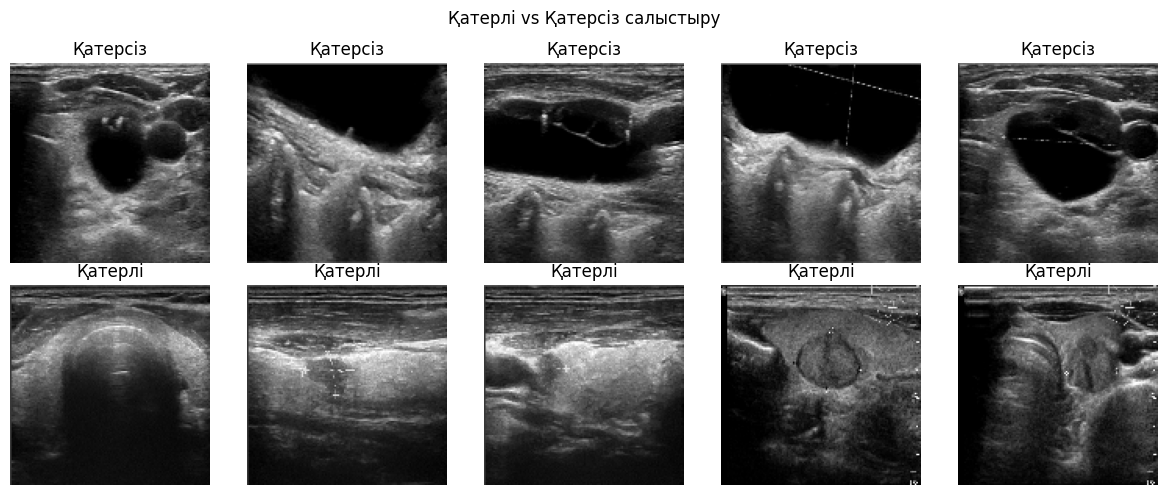

In [114]:
# benign (0) суреттер
benign_imgs = X_data[y_data == 0][:5]
malig_imgs = X_data[y_data == 1][:5]

plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(benign_imgs[i], cmap='gray')
    plt.title("Қатерсіз")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(malig_imgs[i], cmap='gray')
    plt.title("Қатерлі")
    plt.axis('off')

plt.suptitle("Қатерлі vs Қатерсіз салыстыру")
plt.tight_layout()
plt.show()


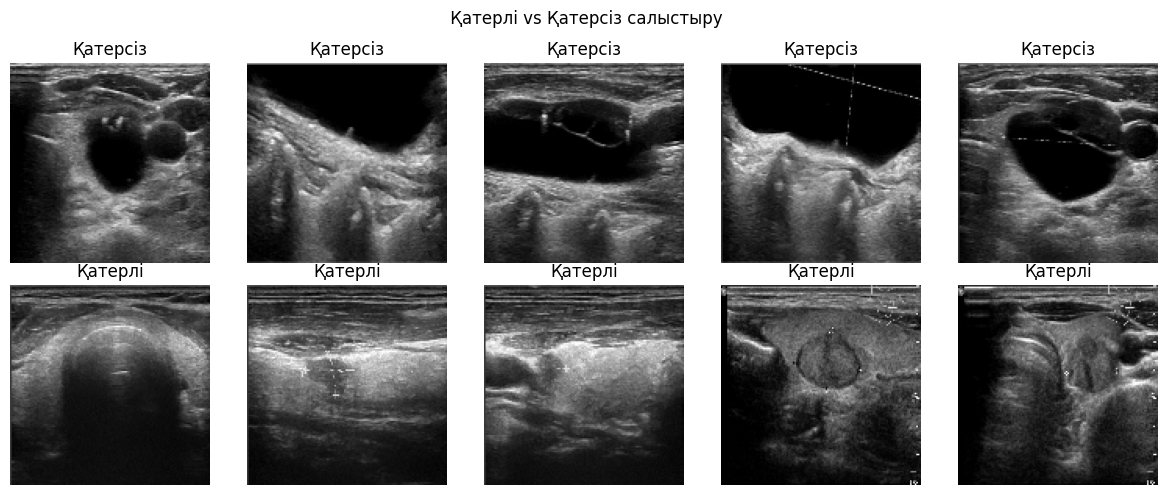

In [116]:
#  benign (0) суреттер
benign_imgs = X_data[y_data == 0][:5]
malig_imgs = X_data[y_data == 1][:5]

plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(benign_imgs[i], cmap='gray')
    plt.title("Қатерсіз")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(malig_imgs[i], cmap='gray')
    plt.title("Қатерлі")
    plt.axis('off')

plt.suptitle(" Қатерлі vs Қатерсіз салыстыру")
plt.tight_layout()
plt.show()

---

##  Этап 4 — Деректер дайындау

###  Мақсат:

Модель оқыту үшін біз суреттер мен белгілерді дайындауымыз керек:

-  Нормализация (`0–1` аралығы)
-  Класстар тең болу үшін `stratified split`
-  Кескіндерді кеңейту (augmentation)
-  Класстар дисбалансын теңестіру үшін `class_weight='balanced'`

---

###  4.1 Нормализация және өлшем келтіру

- `X_data` → `.reshape(-1, 128, 128, 1)` (CNN кірісі үшін)
- `X / 255.` — пиксель мәндерін 0–1 шкалаға түсіру

---

###  4.2 Train / Validation бөлу

- 80% — `X_train`
- 20% — `X_val`
- Stratified (`stratify=y`) — дисбаланс бұзылмауы үшін

---

###  4.3 Класстар балансын ескеру

- `class_weight='balanced'` параметрі арқылы keras.fit кезінде есептеу

---

### 4.4 Augmentation (опционалды)

- `ImageDataGenerator` арқылы:
  - Flip, rotation, zoom, shift

---


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Train/Test бөлу (stratify бойынша тең пропорция сақтау)
X_train, X_val, y_train, y_val = train_test_split(
    X_data,
    y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

print(f" X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f" y_train кластар балансы: {np.bincount(y_train)}")

# 2. Кластар салмағын есептеу (disbalance болғанда қажет)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(" class_weight:", class_weights)


 X_train: (2718, 128, 128, 1), X_val: (680, 128, 128, 1)
 y_train кластар балансы: [1002 1716]
 class_weight: {0: np.float64(1.3562874251497006), 1: np.float64(0.791958041958042)}


In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)



train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [122]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Augmentation тек train-ге
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 2. Validation генератор (augmentation қолданбаймыз)
val_datagen = ImageDataGenerator()

# 3. Деректер генерациясы
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=32,
    shuffle=False
)


In [126]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # LR-ді 2 есе азайту
    patience=2,         # 2 эпохадан кейін өзгеріс болмаса
    min_lr=1e-6,
    verbose=1
)


---

##  Этап 5 — Нейрондық желі арқылы модель құру

Біз екі түрлі тәсілмен модель құрып, салыстырамыз:

###  5.1 Базалық CNN (қолмен жасалған)

Қарапайым Convolutional Neural Network архитектурасы:

- 2–3 Conv2D қабат
- Activation: ReLU
- MaxPooling2D
- Flatten → Dense(128) → Dropout → Output

> Бұл архитектура жеңіл және CPU-да жылдам оқытылады.

---

###  5.2 Transfer Learning — MobileNetV2

**MobileNetV2** — алдын ала ImageNet деректерінде үйретілген,  
ресурстарға оңтайлы, дәлдігі жоғары модель.

- Input shape: `(128, 128, 3)` — grayscale → RGB конверсия қажет
- Conv базаны қатырып, тек `classifier` бөлігін оқытамыз
- Артықшылығы: аз дерекпен де жақсы нәтиже

---

In [128]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Модель архитектурасы
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

# Grayscale → 3-channel RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze conv layers

# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

mobilenet_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

mobilenet_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

---

##  Этап 6 — Модельді оқыту

###  Мақсат:

Модельдерді тиімді түрде оқытып, overfitting-ке жол бермей,  
validation деректерінде нақты нәтиже беруге жету.

---

###  Параметрлер:

-  `EarlyStopping`: val_loss нашарлаған жағдайда оқытуды тоқтату
-  `ModelCheckpoint`: ең жақсы модельді автоматты түрде сақтау
-  Эпох саны: **40**
-  Мониторинг: `val_loss`, `val_accuracy`
-  `class_weight='balanced'` қолдану — кластар дисбалансын ескеру

---


In [133]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 2. ModelCheckpoint
checkpoint = ModelCheckpoint(
    "cnn_model_best.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 3. ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 4. Оқыту (генератор арқылы, augmentation қолдана отырып)
history_cnn = cnn_model.fit(
    train_generator,                       
    validation_data=val_generator,           
    epochs=40,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5601 - loss: 0.7389
Epoch 1: val_accuracy improved from -inf to 0.62794, saving model to cnn_model_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.5605 - loss: 0.7385 - val_accuracy: 0.6279 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5929 - loss: 0.6874
Epoch 2: val_accuracy did not improve from 0.62794
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - accuracy: 0.5921 - loss: 0.6875 - val_accuracy: 0.4544 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.4616 - loss: 0.6941
Epoch 3: val_accuracy did not improve from 0.62794
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step - accuracy: 0.4618 - loss: 0.6941 - val_accuracy: 0.5191 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5128 - loss: 0.6900
Epoch 4: val_accuracy did not improve from 0.62794
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.5126 - loss: 0.6901 - val_accuracy: 0.4294 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 5/40
85/85 ━━━━

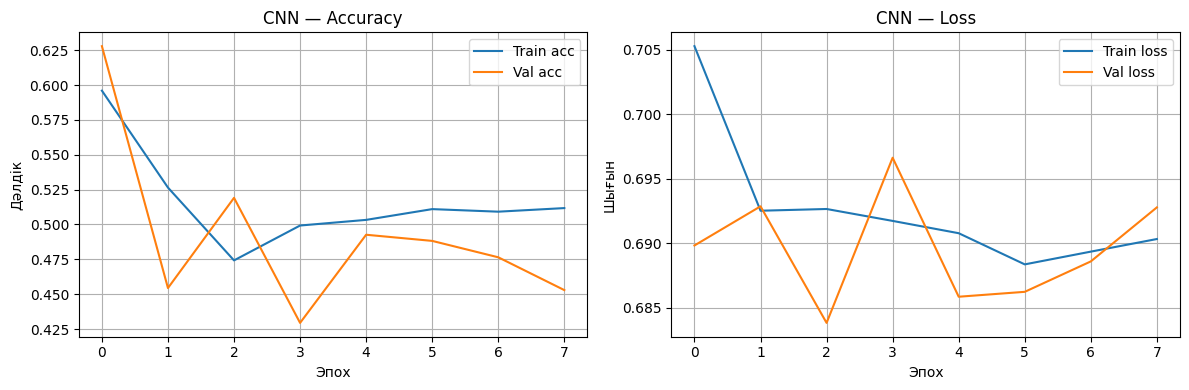

In [134]:
def plot_training_history(history, title=' Оқыту процесі'):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title(f'{title} — Accuracy')
    plt.xlabel('Эпох')
    plt.ylabel('Дәлдік')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title(f'{title} — Loss')
    plt.xlabel('Эпох')
    plt.ylabel('Шығын')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Визуализация
plot_training_history(history_cnn, title="CNN")


---

##  Этап 6 — MobileNetV2 моделін оқыту

MobileNetV2 моделі — алдын ала үйретілген жеңіл әрі дәлдігі жоғары архитектура.  
Біз тек classifier бөлігін ғана қайта оқытамыз (`conv` қабаттар қатырылады).

Модельді `EarlyStopping` және `ModelCheckpoint` көмегімен 15 эпоха оқытамыз.

---


In [136]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. ImageDataGenerator (RGB)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

# 2. Generator
train_generator = train_datagen.flow(
    X_train_rgb, y_train, batch_size=32, shuffle=True
)
val_generator = val_datagen.flow(
    X_val_rgb, y_val, batch_size=32, shuffle=False
)

# 3. Callbacks
early_stop_m = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_m = ModelCheckpoint(
    "mobilenetv2_best.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_m = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 4. Оқыту
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop_m, checkpoint_m, reduce_lr_m],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4828 - loss: 0.8260
Epoch 1: val_accuracy improved from -inf to 0.59265, saving model to mobilenetv2_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 323ms/step - accuracy: 0.4830 - loss: 0.8253 - val_accuracy: 0.5926 - val_loss: 0.6667 - learning_rate: 0.0010
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5271 - loss: 0.6937
Epoch 2: val_accuracy did not improve from 0.59265
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.5270 - loss: 0.6937 - val_accuracy: 0.4412 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4970 - loss: 0.6878
Epoch 3: val_accuracy did not improve from 0.59265

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.4971 - loss: 0.6878 - val_accuracy: 0.4441 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5260 - loss: 0.6857
Epoch 4: val_accuracy improved from 0.59265 to 0.59412, saving model to mobilenetv2_best.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.5262 - loss: 0.6857 - val_accuracy: 0.5941 - val_loss: 0.6640 - learning_rate: 5.0000e-04
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5908 - loss: 0.6850
Epoch 5: val_accuracy did not improve from 0.59412
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.5905 - loss: 0.6850 - val_accuracy: 0.5162 - val_loss: 0.6972 - learning_rate: 5.0000e-04
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5926 - loss: 0.6757
Epoch 6: val_accuracy did not improve from 0.59412

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step - accuracy: 0.5924 - loss: 0.6757 - val_accuracy: 0.5691 - val_loss: 0.6761 - learning_rate: 5.0000e-04
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5698 - loss: 0.6748
Epoch 7: val_accuracy did not improve from 0.59412
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.5699 - loss: 0.674

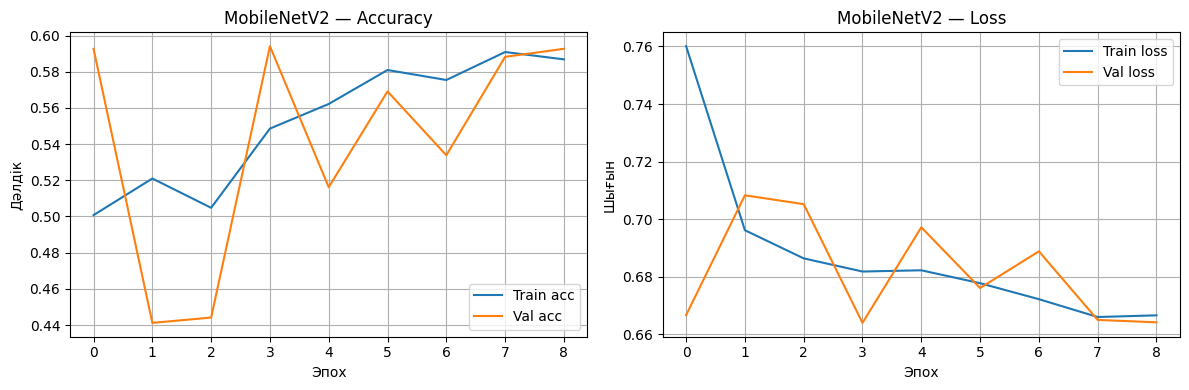

In [137]:
plot_training_history(history_mobilenet, title="MobileNetV2")


---

##  Этап 7 — Бағалау және интерпретация

###  Мақсат:

Оқытылған модельдердің сапасын сандық және визуал түрінде бағалау.

---

###  Метрикалар:

- **Accuracy** — нақты дұрыс классификация үлесі
- **Precision / Recall / F1-score** — қате болдырмау сапасы
- **ROC-AUC** — 0 мен 1 аралығындағы сенімділік шегі

---

###  Визуализациялар:

- Confusion Matrix
- ROC-кривая
- Grad-CAM — суреттен модель қандай аймаққа "қарағанын" көрсету

---

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
 CNN Classification Report:
              precision    recall  f1-score   support

           0      0.380     0.478     0.423       251
           1      0.640     0.543     0.588       429

    accuracy                          0.519       680
   macro avg      0.510     0.511     0.505       680
weighted avg      0.544     0.519     0.527       680



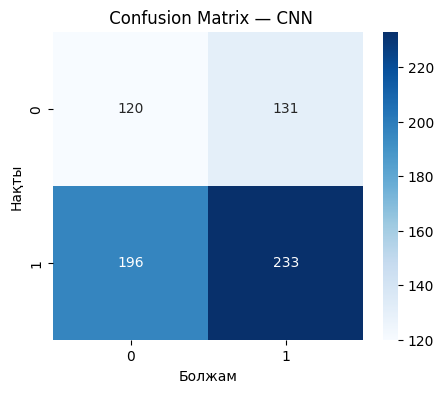

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Болжау
y_pred_cnn = (cnn_model.predict(X_val) > 0.5).astype("int32")

# Classification Report
print(" CNN Classification Report:")
print(classification_report(y_val, y_pred_cnn, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_cnn)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(" Confusion Matrix — CNN")
plt.xlabel("Болжам")
plt.ylabel("Нақты")
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


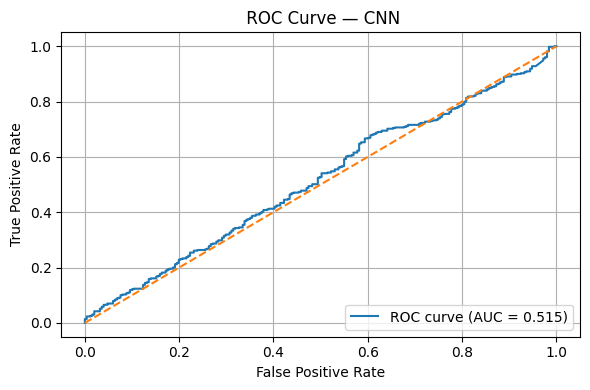

In [144]:
from sklearn.metrics import roc_curve, auc

# ROC — CNN
y_proba_cnn = cnn_model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_proba_cnn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve — CNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step
 MobileNetV2 Classification Report:
              precision    recall  f1-score   support

           0      0.403     0.207     0.274       251
           1      0.639     0.821     0.718       429

    accuracy                          0.594       680
   macro avg      0.521     0.514     0.496       680
weighted avg      0.552     0.594     0.554       680



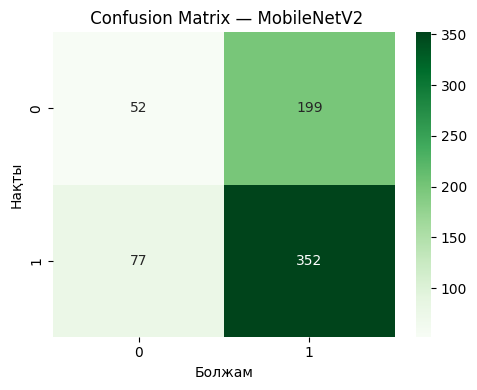

In [146]:
#  MobileNetV2 — болжау
y_pred_mob = (mobilenet_model.predict(X_val_rgb) > 0.5).astype("int32")

#  Classification Report
print(" MobileNetV2 Classification Report:")
print(classification_report(y_val, y_pred_mob, digits=3))

#  Confusion Matrix
cm_mob = confusion_matrix(y_val, y_pred_mob)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_mob, annot=True, fmt='d', cmap='Greens')
plt.title(" Confusion Matrix — MobileNetV2")
plt.xlabel("Болжам")
plt.ylabel("Нақты")
plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step


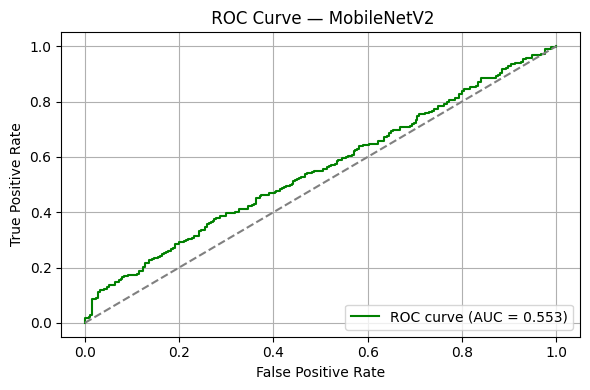

In [147]:
#  Мүмкіндік мәні (probability)
y_proba_mob = mobilenet_model.predict(X_val_rgb)
fpr_mob, tpr_mob, _ = roc_curve(y_val, y_proba_mob)
roc_auc_mob = auc(fpr_mob, tpr_mob)

#  ROC кривая
plt.figure(figsize=(6, 4))
plt.plot(fpr_mob, tpr_mob, label=f"ROC curve (AUC = {roc_auc_mob:.3f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve — MobileNetV2")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

---

##  Этап 7.3 — Grad-CAM визуализациясы

###  Мақсат:

Grad-CAM көмегімен модельдің кескіннің қай аймағына назар аударғанын көрсету.  
Бұл дәрігерге шешім қабылдау процесін түсінуге көмектеседі.

###  Механизм:

- Соңғы `Conv2D` қабаттың градиентін алып, "heatmap" құрамыз
- Бұл heatmap — модель үшін маңызды аймақтарды көрсетеді

> Grad-CAM — интерпретацияға арналған explainable AI әдісі

---

In [151]:
import tensorflow as tf
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Модель: Conv → GlobalPool → Dense
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [153]:
def show_gradcam(original_img, heatmap, alpha=0.4):
    # Rescale heatmap
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cm.jet(heatmap)[:, :, :3]  # RGBA → RGB

    # Superimpose
    superimposed_img = heatmap_colored * alpha + original_img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(" Grad-CAM")
    plt.show()


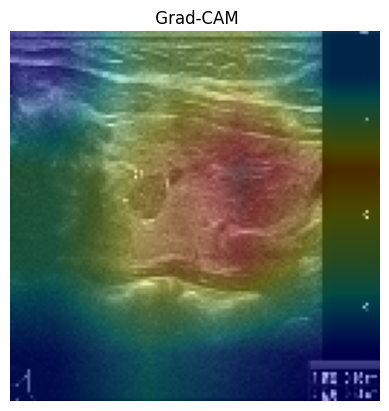

In [155]:
# 1. Суретті таңдау (RGB 128x128)
idx = 0
sample = X_val_rgb[idx:idx+1]  # (1, 128, 128, 3)

# 2. Heatmap генерация
heatmap = make_gradcam_heatmap(sample, mobilenet_model, last_conv_layer_name="Conv_1")  # MobileNetV2 соңғы conv қабаты

# 3. Бастапқы сурет (нормалды range)
original_img = sample[0]
show_gradcam(original_img, heatmap)
